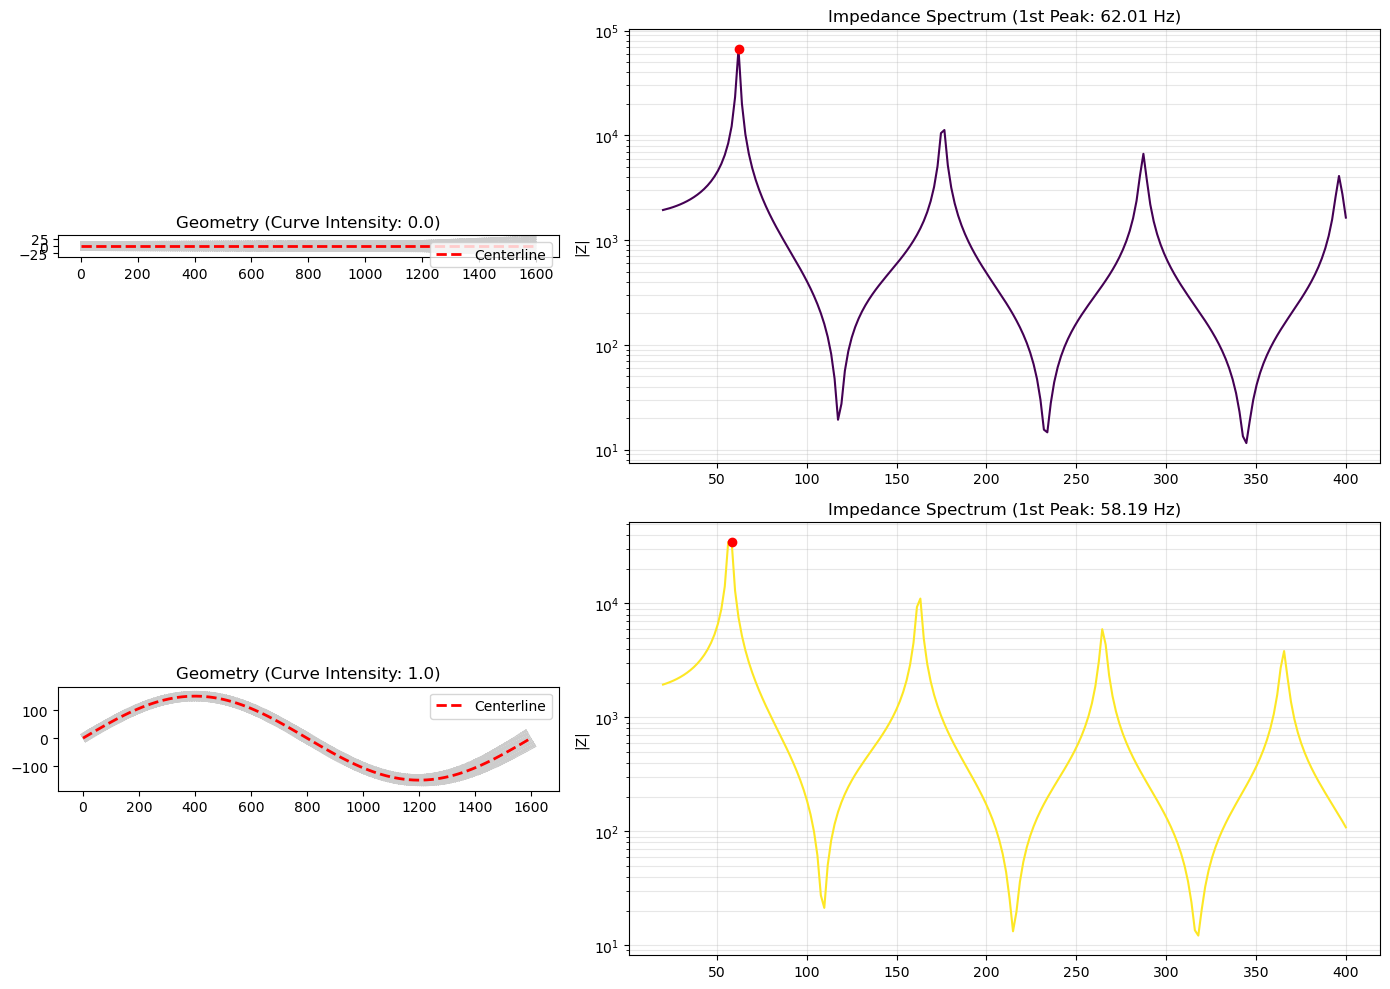

In [2]:
import numpy as np
import skfem as fem
from skfem.helpers import dot, grad
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# --- CONSTANTS ---
C_SPEED = 343000.0  # mm/s

# --- 1. GEOMETRY & MESHING ---

def get_didgeridoo_mesh(segments, curve_func, n_z=250, n_r=12):
    z_min, z_max = segments[0, 0], segments[-1, 0]
    z_vals = np.linspace(z_min, z_max, n_z)
    r_vals = np.linspace(-1, 1, n_r)
    
    mesh_log = fem.MeshTri.init_tensor(z_vals, r_vals)
    new_p = np.zeros_like(mesh_log.p)
    
    for i in range(mesh_log.p.shape[1]):
        s_val = mesh_log.p[0, i]
        rel_r = mesh_log.p[1, i]
        
        p0 = curve_func(s_val)
        p_eps = curve_func(s_val + 0.1) 
        diff = p_eps - p0
        dist = np.linalg.norm(diff)
        
        tangent = diff / dist if dist > 0 else np.array([1.0, 0.0])
        normal = np.array([-tangent[1], tangent[0]])
        
        radius = np.interp(s_val, segments[:, 0], segments[:, 1]) / 2.0
        new_p[:, i] = p0 + (radius * rel_r * normal)
        
    return fem.MeshTri(new_p, mesh_log.t)

def plot_didgeridoo_mesh(ax, mesh, segments, curve_func, title="Mesh"):
    # Plot the Mesh
    ax.triplot(mesh.p[0], mesh.p[1], mesh.t.T, color='gray', lw=0.5, alpha=0.4)
    
    # --- ADDED: Plot the Centerline Curve ---
    z_range = np.linspace(segments[0, 0], segments[-1, 0], 100)
    curve_points = np.array([curve_func(z) for z in z_range])
    ax.plot(curve_points[:, 0], curve_points[:, 1], 'r--', lw=2, label="Centerline")
    
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.legend(loc='upper right')

# --- 2. FEM & ANALYSIS ---

def get_flat_indices(dofs):
    if isinstance(dofs, dict):
        return np.concatenate([v for v in dofs.values()]).astype(int)
    return dofs.astype(int)

def run_analysis(mesh, segments, curve_func, frequencies):
    basis = fem.Basis(mesh, fem.ElementTriP1())
    
    @fem.BilinearForm
    def stiffness(u, v, w): return dot(grad(u), grad(v))
    @fem.BilinearForm
    def mass(u, v, w): return u * v

    K = stiffness.assemble(basis)
    M = mass.assemble(basis)
    
    bell_pt = curve_func(segments[-1, 0])
    mouth_pt = curve_func(segments[0, 0])
    
    bell_idx = get_flat_indices(basis.get_dofs(lambda x: np.linalg.norm(x - bell_pt[:, None], axis=0) < 80).nodal)
    mouth_idx = get_flat_indices(basis.get_dofs(lambda x: np.linalg.norm(x - mouth_pt[:, None], axis=0) < 20).nodal)
    
    b_mouth = np.zeros(basis.N)
    b_mouth[mouth_idx] = 1.0
    
    z_spectrum = []
    for f in frequencies:
        omega = 2 * np.pi * f
        k = (omega / C_SPEED) - 1j * (1.5e-6 * np.sqrt(f))
        A = K - (k**2) * M
        p = fem.solve(*fem.condense(A, b_mouth, D=bell_idx))
        z_spectrum.append(np.mean(np.abs(p[mouth_idx])))
        
    return np.array(z_spectrum)

# --- 3. MAIN EXECUTION ---

if __name__ == "__main__":
    my_segments = np.array([[0, 32], [1200, 40], [1600, 70]])
    freqs = np.linspace(20, 400, 200) 
    
    curve_levels = [0.0, 1.0]
    fig, axes = plt.subplots(len(curve_levels), 2, figsize=(14, 10), gridspec_kw={'width_ratios': [1, 1.5]})

    for i, c_val in enumerate(curve_levels):
        def sine_curve(s, curve=c_val):
            amplitude = 150 * curve
            wavelength = 1600 
            y = amplitude * np.sin(2 * np.pi * s / wavelength)
            return np.array([s, y])

        # Analysis
        mesh = get_didgeridoo_mesh(my_segments, sine_curve)
        spectrum = run_analysis(mesh, my_segments, sine_curve, freqs)
        
        # Find peaks
        peaks, _ = find_peaks(spectrum)
        if len(peaks) > 0:
            first_peak_freq = freqs[peaks[0]]
            peak_label = f" (1st Peak: {first_peak_freq:.2f} Hz)"
        else:
            peak_label = " (No peak found)"
            first_peak_freq = None

        # Plot Geometry (Now includes the curve)
        plot_didgeridoo_mesh(axes[i, 0], mesh, my_segments, sine_curve, title=f"Geometry (Curve Intensity: {c_val})")
        
        # Plot Impedance
        axes[i, 1].semilogy(freqs, spectrum, label=f"Curve={c_val}", color=plt.cm.viridis(c_val))
        axes[i, 1].set_title(f"Impedance Spectrum{peak_label}")
        axes[i, 1].grid(True, which='both', alpha=0.3)
        axes[i, 1].set_ylabel("|Z|")
        
        if first_peak_freq:
            axes[i, 1].plot(first_peak_freq, spectrum[peaks[0]], 'ro')

    plt.tight_layout()
    plt.show()

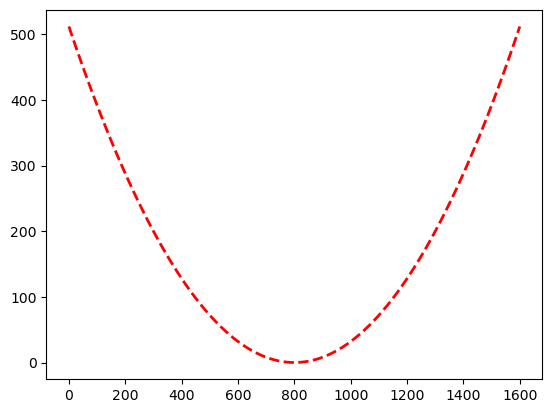

In [42]:
def curve_func(s):
    didge_length = my_segments[-1, 0]
    y = np.power(s-didge_length/2,2)
    y = 0.3*didge_length*y/600000
    return np.array([s, y])

z_range = np.linspace(my_segments[0, 0], my_segments[-1, 0], 100)

curve_points = np.array([curve_func(z) for z in z_range])

plt.plot(curve_points[:, 0], curve_points[:, 1], 'r--', lw=2)


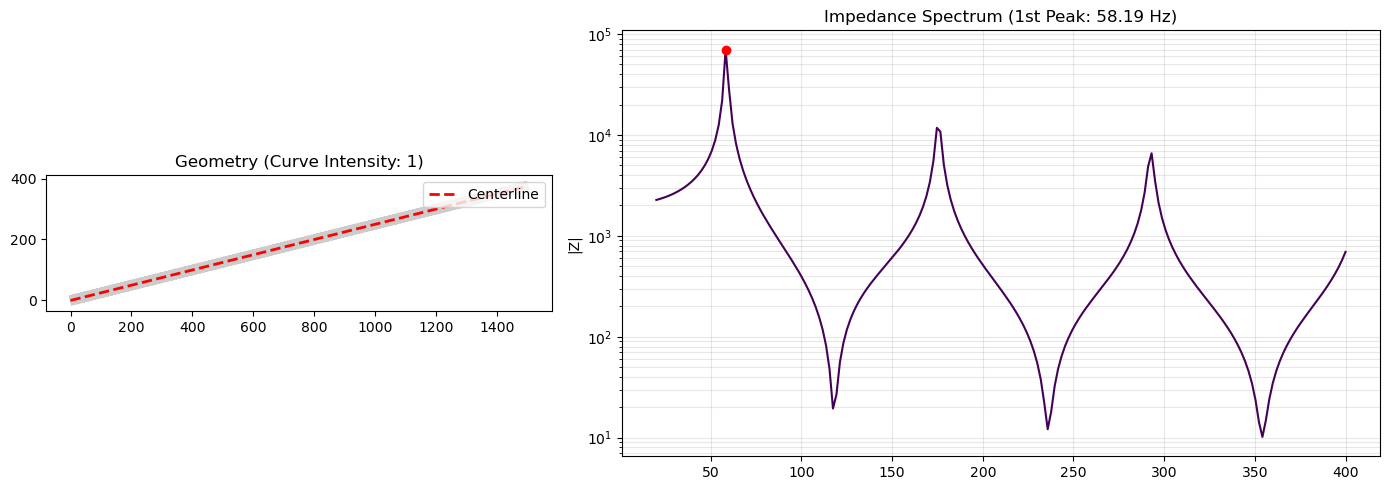

In [65]:
my_segments = np.array([(0.0, 30.0), (51.46899363230762, 33.7784524142553), (85.30423566381049, 27.778931402719003), (146.18854416328128, 29.93556480319699), (179.09381040534882, 28.176128566813905), (259.6802069488814, 28.958055614249236), (285.8190435948692, 32.523925651740726), (371.25522284885295, 28.657844125210218), (419.84135591763703, 29.58434155089998), (466.51643935886017, 29.918981345641743), (527.3904014120826, 31.90101706990902), (531.1184504606866, 34.99886886158793), (602.3168197366772, 32.507540421468754), (662.7828119015719, 36.93351761826125), (696.8927839128953, 35.045862969399295), (746.6898985029628, 36.84736191316634), (815.4460816003736, 39.05244109202236), (832.2110323436855, 43.81877757673142), (848.9759830869973, 48.23024903217608), (865.7409338303091, 51.74295627153961), (882.505884573621, 54.20771815807003), (899.2708353169328, 55.56194698443228), (916.0357860602446, 55.32924009903286), (932.8007368035564, 53.87356959783409), (949.5656875468683, 57.597070298366724), (966.3306382901801, 60.18361651506194), (999.0345487680597, 64.33061402881069), (1015.6645962439811, 65.73163097400256), (1032.2946437199025, 65.17490857100057), (1048.924691195824, 62.75626540369139), (1065.5547386717453, 58.79571998981954), (1082.1847861476667, 54.17039891202623), (1119.7483374925102, 50.13599574849312), (1145.100343149991, 52.07082961850034), (1196.9667987935184, 52.785312404146595), (1275.3325429113545, 51.631734726631564), (1310.4749184562197, 49.258375148257805), (1360.5050929455278, 55.86662095119183), (1432.9324204516163, 57.034846444202294), (1447.2181347373307, 57.6709182777631), (1461.503849023045, 58.180684544167576), (1475.7895633087592, 58.54248286994988), (1490.0752775944734, 58.97267620477503), (1504.3609918801878, 59.524557312640155), (1518.646706165902, 60.26754363477322), (1532.9324204516163, 62.288373855176175), (1547.2181347373307, 64.72655249320907), (1561.503849023045, 67.72346991377412), (1575.7895633087592, 70.39265102058911), (1590.0752775944734, 73.44970066456183), (1604.3609918801878, 77.47427770386149), (1618.646706165902, 82.64877489218449)])
my_segments = np.array([[0.0, 32.0], [1500, 32.0]])
freqs = np.linspace(20, 400, 200) 

fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [1, 1.5]})

c_val=1
def sine_curve(s, curve=c_val):
    amplitude = 150 * curve
    wavelength = 1600 
    y = amplitude * np.sin(2 * np.pi * s / wavelength)
    return np.array([s,0.25*s])

# Analysis
mesh = get_didgeridoo_mesh(my_segments, sine_curve)
spectrum = run_analysis(mesh, my_segments, sine_curve, freqs)

# Find peaks
peaks, _ = find_peaks(spectrum)
if len(peaks) > 0:
    first_peak_freq = freqs[peaks[0]]
    peak_label = f" (1st Peak: {first_peak_freq:.2f} Hz)"
else:
    peak_label = " (No peak found)"
    first_peak_freq = None

# Plot Geometry (Now includes the curve)
plot_didgeridoo_mesh(axes[0], mesh, my_segments, sine_curve, title=f"Geometry (Curve Intensity: {c_val})")

# Plot Impedance
axes[1].semilogy(freqs, spectrum, label=f"Curve={c_val}", color=plt.cm.viridis(c_val))
axes[1].set_title(f"Impedance Spectrum{peak_label}")
axes[1].grid(True, which='both', alpha=0.3)
axes[1].set_ylabel("|Z|")

if first_peak_freq:
    axes[1].plot(first_peak_freq, spectrum[peaks[0]], 'ro')

plt.tight_layout()
plt.show()

,note_name,cent_diff,note_nr,freq,impedance,rel_imp
0,A1,32.368344,-36,56.037991,27.648045,1.000000
1,E3,42.368344,-17,168.897013,14.306686,0.517457
2,C#4,27.368344,-8,281.599312,9.618349,0.347885
3,G4,12.368344,-2,394.805971,7.087279,0.256339
4,B4,47.368344,2,507.583021,5.393394,0.195073
5,D#5,-2.631656,6,621.308795,4.296886,0.155414
6,F#5,-12.631656,9,734.609291,3.484345,0.126025
7,G#5,32.368344,11,846.285126,2.850370,0.103095
8,B5,-47.631656,14,960.960509,2.441077,0.088291


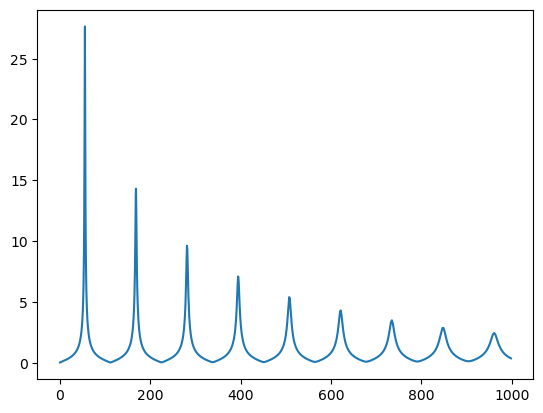

In [59]:
import sys
sys.path.append("../../")

from didgelab.calc.sim.sim import compute_impedance_iteratively, get_notes, compute_impedance, create_segments, get_log_simulation_frequencies
from didgelab.calc.geo import Geo, geotools

geo = Geo(my_segments.tolist())
freqs = get_log_simulation_frequencies(1, 1000, 5)
segments = create_segments(geo)
impedances = compute_impedance(segments, freqs)
notes = get_notes(freqs, impedances)
plt.plot(freqs, impedances)
notes